## New York City property sales project

The goal of this analysis is to get a general idea of how sales of properties differ from 2021 to now and how they are distributed among the five boroughs. We will also pull an additional dataset about vacancy to get an idea of the number of vacancies per borough. 

In [1]:
# import necessary libraries 

import requests
from urllib.request import urlretrieve
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
from bs4 import BeautifulSoup

First, before looking at any other data, we can look at some general metrics that will allow us to get an overview of the boroughs of New York City. This information can be found at https://livabilityindex.aarp.org.


In [2]:
boroughs = ['manhattan','bronx','brooklyn','queens','statenisland']
populations = [1631993,1435068,2589974,2287388,474893]
median_income = [102108,46505,68375,73332,89241]
livability_index = [65,63,65,61,61]
intro_info = pd.DataFrame({'boroughs':boroughs,'populations':populations,'median_income':median_income,
             'livability_index':livability_index})
intro_info.sort_values(by='median_income', ascending=False)

,boroughs,populations,median_income,livability_index
0,manhattan,1631993,102108,65
4,statenisland,474893,89241,61
3,queens,2287388,73332,61
2,brooklyn,2589974,68375,65
1,bronx,1435068,46505,63


All of the data we will be looking at in this project is labeled with one of the five boroughs of New York City: Manhattan, Bronx, Brooklyn, Queens, Staten Island. The highest income area is Manhattan, so we probably expect the highest mean sales price to be there, and the lowest mean sales price for Bronx. Queens and Brooklyn have the highest populations but that may not mean highest volume of sales because the dataset includes commercial buildings, which may concentrate in Manhattan.

# Rolling Sales Data
The Department of Finance’s Rolling Sales files lists properties that sold in the last twelve-month period in New York City for tax class 1, 2, and 4.  These files include:

the neighborhood;
building type;
square footage;
other data.

In [3]:
## Gather all the URLs where the files are, and the file names for retrieval

url_man_rolling = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_manhattan.xlsx'
url_brx_rolling = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_bronx.xlsx'
url_bry_rolling = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_brooklyn.xlsx'
url_que_rolling = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_queens.xlsx'
url_sta_rolling = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/rollingsales_statenisland.xlsx'

urls = [url_man_rolling,url_brx_rolling,url_bry_rolling,url_que_rolling,url_sta_rolling]

file_man = 'rollingsales_manhattan.xlsx'
file_brx = 'rollingsales_bronx.xlsx'
file_bry = 'rollingsales_brooklyn.xlsx'
file_que = 'rollingsales_queens.xlsx'
file_sta = 'rollingsales_statenisland.xlsx'

filename = [file_man,file_brx,file_bry,file_que,file_sta]


for i in range(5):
    urlretrieve(urls[i],filename[i])

In [4]:
#Load data from files for all 5 Boroughs 

df_man_roll = pd.read_excel('rollingsales_manhattan.xlsx',header=4)
df_brx_roll = pd.read_excel('rollingsales_bronx.xlsx',header=4)
df_bry_roll = pd.read_excel('rollingsales_brooklyn.xlsx',header=4)
df_que_roll = pd.read_excel('rollingsales_queens.xlsx',header=4)
df_sta_roll = pd.read_excel('rollingsales_statenisland.xlsx',header=4)


## Clean data

Data comes in 5 batches for the 5 boroughs of New York City, in the next few steps we are going to combine the data and then clean and format

In [5]:
#combine all borough data into one

#borough key: 1:'manhattan', 2:'bronx', 3:'brooklyn', 4:'queens', 5:'statenisland'

rolling_sales = pd.concat([df_man_roll,df_brx_roll,df_bry_roll,df_que_roll,df_sta_roll])

rolling_sales['BOROUGH'].count()

# How many rows of data do we have?

98270

In [8]:
# Extract only sales for year 2022, 2021 sales will come in later in another file 

sales_22 = rolling_sales[rolling_sales['SALE DATE'].dt.year == 2022]


In [10]:
#Easement column is empty

#the type for columns need to be changed to categorical for alot of columns

sales_22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34867 entries, 2 to 9085
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         34867 non-null  int64         
 1   NEIGHBORHOOD                    34867 non-null  object        
 2   BUILDING CLASS CATEGORY         34867 non-null  object        
 3   TAX CLASS AT PRESENT            34813 non-null  object        
 4   BLOCK                           34867 non-null  int64         
 5   LOT                             34867 non-null  int64         
 6   EASEMENT                        0 non-null      float64       
 7   BUILDING CLASS AT PRESENT       34813 non-null  object        
 8   ADDRESS                         34867 non-null  object        
 9   APARTMENT NUMBER                8813 non-null   object        
 10  ZIP CODE                        34866 non-null  float64       
 11  RES

In [11]:
#Change type to category for columns that are categorical

obj_cats = ['BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE','BOROUGH',
            'BUILDING CLASS AT TIME OF SALE','BUILDING CLASS AT PRESENT','BLOCK','LOT','ZIP CODE','YEAR BUILT']

for colname in obj_cats:
    sales_22[colname] = sales_22[colname].astype('category') 


sales_22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34867 entries, 2 to 9085
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         34867 non-null  category      
 1   NEIGHBORHOOD                    34867 non-null  object        
 2   BUILDING CLASS CATEGORY         34867 non-null  category      
 3   TAX CLASS AT PRESENT            34813 non-null  category      
 4   BLOCK                           34867 non-null  category      
 5   LOT                             34867 non-null  category      
 6   EASEMENT                        0 non-null      float64       
 7   BUILDING CLASS AT PRESENT       34813 non-null  category      
 8   ADDRESS                         34867 non-null  object        
 9   APARTMENT NUMBER                8813 non-null   object        
 10  ZIP CODE                        34866 non-null  category      
 11  RES

/var/folders/76/ytg4_01s0zj0zkszt775_g3h0000gn/T/ipykernel_21448/3274903180.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_22[colname] = sales_22[colname].astype('category')


In [12]:
#Formatting:  column names switched to lower case and and no spaces

sales_22.columns = sales_22.columns.str.lower()
sales_22.columns = sales_22.columns.str.replace(" ", "_")
sales_22.columns

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'easement',
       'building_class_at_present', 'address', 'apartment_number', 'zip_code',
       'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_time_of_sale', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date'],
      dtype='object')

In [13]:
#drop empty column of easement

sales_22.drop(columns='easement',inplace=True)
sales_22.columns

/Users/snoopymartinmar/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'building_class_at_present',
       'address', 'apartment_number', 'zip_code', 'residential_units',
       'commercial_units', 'total_units', 'land_square_feet',
       'gross_square_feet', 'year_built', 'tax_class_at_time_of_sale',
       'building_class_at_time_of_sale', 'sale_price', 'sale_date'],
      dtype='object')

In [14]:
# Look at overall shape of the numbers 

sales_22[['sale_price']].describe().apply(lambda s: s.apply('{0:,f}'.format)).transpose()

,count,mean,std,min,25%,50%,75%,max
sale_price,"34,867.000000","1,556,578.843692","13,716,696.327449",0.000000,0.000000,"620,000.000000","1,135,000.000000","931,000,000.000000"


## Sales prices 2022 summary statistics

Prices vary a large amount. There are a significant amount of 0 dollar sales, and some sales reaching close to a billion dollars. We will have to separate and drop those 0 dollar sales because they do not represent the value of the property.

In [15]:
# How many sales are 100million or more?

high_sales = sales_22[sales_22['sale_price']>99999999]
high_sales['sale_price'].count()

36

In [16]:
#A $0 sale indicates that there was a transfer of ownership without a cash consideration.

# How many sales are $0 dollar transactions?

zero_22_sales = sales_22[sales_22['sale_price'] == 0]
zero_22_sales['sale_price'].count()

8930

In [17]:
# There are sales under a thousand dollars that are suspeciously low

low_22_sales = sales_22[sales_22['sale_price'].between(1,999)]

## difference between $0-999 and just $0

low_22_sales['borough'].count()

395

We can be fairly certain that 0 and under a thousand dollar sales prices do not represent the actual value of the building. We are going to separate the 0 and <1000 dollar sales prices for the rest of our data that may more accurately represent the value of the properties in the data set.

In [18]:
sales_22 = sales_22[~sales_22['sale_price'].between(0,999)]

In [19]:
# We are going to reset the index so that it enumerates correctly

sales_22.reset_index(inplace=True, drop=True)

In [20]:
# We can add a month column so that we can more easily visualize data moving on

sales_22['sale_month'] = sales_22.loc[:,'sale_date'].dt.to_period('M')

In [21]:
# What percentage of rows is na for each column

sales_22.isnull().sum()/len(sales_22)*100

borough                            0.000000
neighborhood                       0.000000
building_class_category            0.000000
tax_class_at_present               0.211416
block                              0.000000
lot                                0.000000
building_class_at_present          0.211416
address                            0.000000
apartment_number                  70.785373
zip_code                           0.003915
residential_units                 29.872367
commercial_units                  52.490016
total_units                       26.458382
land_square_feet                  55.904001
gross_square_feet                 55.904001
year_built                         7.250803
tax_class_at_time_of_sale          0.000000
building_class_at_time_of_sale     0.000000
sale_price                         0.000000
sale_date                          0.000000
sale_month                         0.000000
dtype: float64

Now that we have taken out sales prices that we suspect are not representative of the real value of the building, we can again look at the sale prices:

In [99]:
## Create two new sale price columns for easier visualization

## Lets take a look at our newly created columns

sales_22['sale_inmillions'].sum()
sales_22['sale_inthousands'] = sales_22['sale_price']/1000
sales_22['sale_inmillions'] = sales_22['sale_price']/1000000
sales_22[['sale_price','sale_inthousands','sale_inmillions']].describe()

,sale_price,sale_inthousands,sale_inmillions
count,2.554200e+04,25542.000000,25542.000000
mean,2.124862e+06,2124.861956,2.124862
std,1.598852e+07,15988.520699,15.988521
min,1.000000e+03,1.000000,0.001000
25%,5.420000e+05,542.000000,0.542000
50%,8.380000e+05,838.000000,0.838000
75%,1.450000e+06,1450.000000,1.450000
max,9.310000e+08,931000.000000,931.000000


In [25]:
# Average sales by month for the year 2022 for all Boroughs

sm = sales_22[['sale_month','sale_inthousands']].groupby(by='sale_month').mean()
sm.reset_index(inplace=True)
sm

,sale_month,sale_inthousands
0,2022-01,1658.682906
1,2022-02,1844.523509
2,2022-03,2739.982382
3,2022-04,2457.344272
4,2022-05,1645.474476


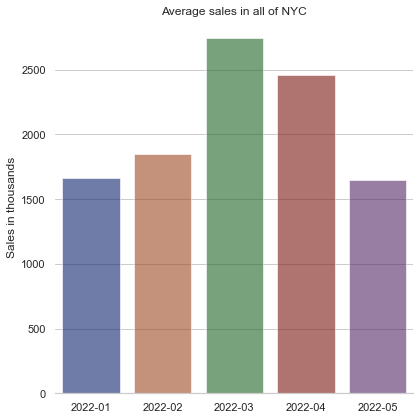

In [26]:
# Lets take a look at the data

sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=sm, kind="bar",
    x="sale_month", y="sale_inthousands",
    palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Sales in thousands")
plt.title('Average sales in all of NYC')
plt.show()


There seems to be a peak in the month of march, but that on its own doesn't tell us much without looking at other years for comparison.

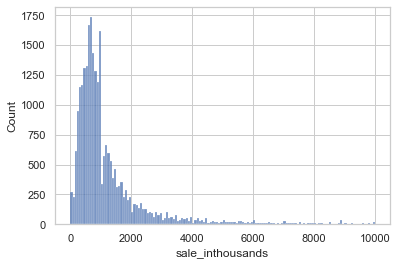

In [27]:
# What is the distribution of sales prices for all of 2022 so far?


sns.histplot(data=sales_22[sales_22['sale_inthousands']<10000]['sale_inthousands'],bins=140)
plt.show()

Sales are heavily right-tailed, we know that 3/4 of sales are under 1.5 million dollars, but they go up to about a billion dollars

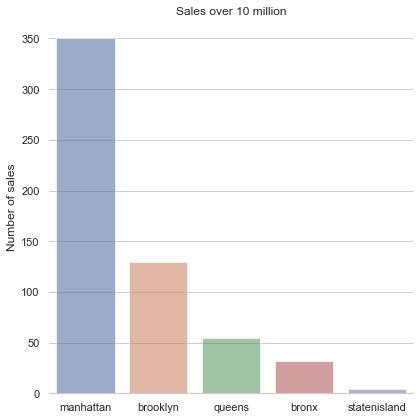

In [28]:
# Which borough has the biggest price tag sales? Count of sales over 10 million

over_10mill = sales_22[sales_22['sale_price']>10000000]['borough'].value_counts()
over_10mill = over_10mill.reset_index()

over_10mill['index'].replace({1:'manhattan', 2:'bronx', 3:'brooklyn', 4:'queens', 5:'statenisland'}, inplace=True)
over_10mill.rename(columns = {'index':'borough','borough':'count'},inplace=True)


# Graph it 

sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=over_10mill, kind="bar",
    x="borough", y="count",
    palette="deep", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Number of sales")
plt.title('Sales over 10 million')
plt.show()



Most big sales happen in Manhattan. As expected, our highest income borough also has the highest number of big price tag properties (>10million)

## Correlation analysis 

We expect all the quantitative columns to have a positive relationship with price. The more units or square footage the higher the price of the property will be. We are going to graph them one by one:

In [37]:
# Let's analyze each quantitative column one by one and see their relationship to price

# We are going to take out the big outliers so that we can easily see the correlation

criteria_res_units = (sales_22['sale_price'].between(1000,50000000)) & (sales_22['residential_units'].between(1,200))
criteria_com_units =  (sales_22['sale_price'].between(1000,50000000)) & (sales_22['commercial_units'].between(1,25))
criteria_tot_units = (sales_22['sale_price'].between(1000,50000000)) & (sales_22['total_units'].between(1,200)) 
criteria_lan_sqfeet =  (sales_22['sale_price'].between(1000,50000000)) & (sales_22['land_square_feet'].between(1,50000)) 
criteria_gro_sqfeet =  (sales_22['sale_price'].between(1000,50000000)) & (sales_22['gross_square_feet'].between(1,10000))

non_zero_res = sales_22[criteria_res_units]
non_zero_com = sales_22[criteria_com_units]
non_zero_tot = sales_22[criteria_tot_units]
non_zero_lan = sales_22[criteria_lan_sqfeet]
non_zero_gro = sales_22[criteria_gro_sqfeet]

In [38]:
# define a function for our 5 different scatterplots


def scatterplot(df, x, y, xlabel, ylabel):
    plt.scatter(x= x, y= y, data=df)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()
    

Correlation between Number of residential units and Sale price:

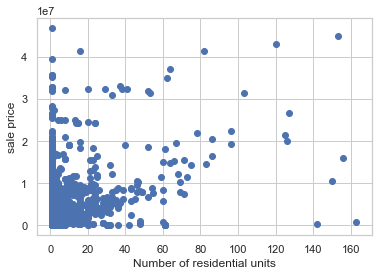

In [31]:
scatterplot(non_zero_res,'residential_units','sale_price','Number of residential units','sale price')

Correlation between Number of commercial units and Sale price:

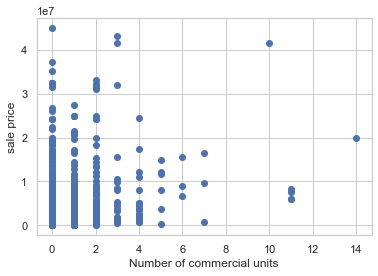

In [32]:
scatterplot(non_zero_res,'commercial_units','sale_price','Number of commercial units','sale price')

Correlation between Total number of units and Sale price:

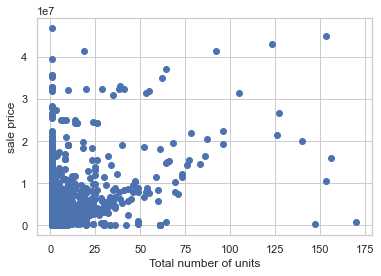

In [33]:
scatterplot(non_zero_res,'total_units','sale_price','Total number of units','sale price')

Correlation between Land square footage and Sale price:

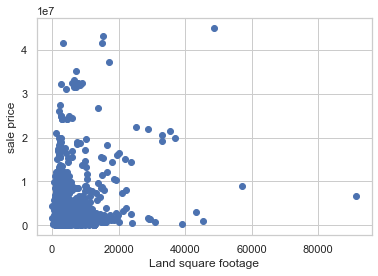

In [34]:
scatterplot(non_zero_res,'land_square_feet','sale_price','Land square footage','sale price')

Correlation between Gross square footage and Sale price:

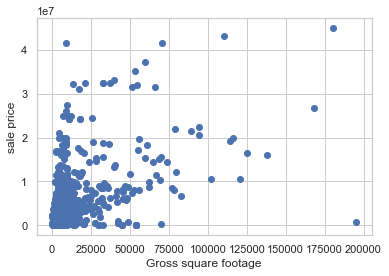

In [35]:
scatterplot(non_zero_res,'gross_square_feet','sale_price','Gross square footage','sale price')

As expected, there is a positive relationship between all quantitative columns and sale price. There would need to be further research to find out how strongly and how much the variables explain the price.

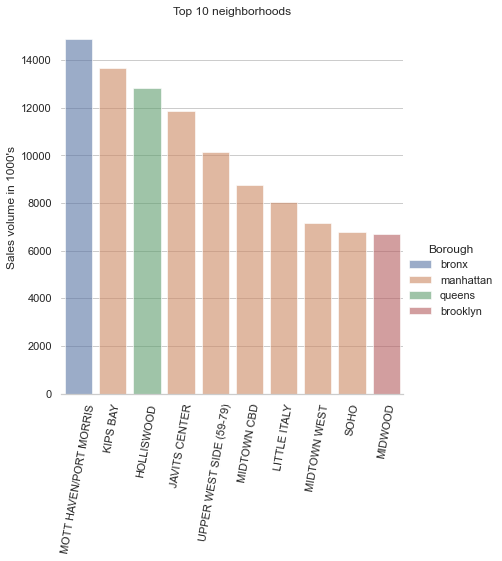

In [39]:
#Top 10 neighborhoods by average sales

top_neigh = sales_22[['neighborhood','borough','sale_inthousands']]
nbhood_avg_sales = top_neigh.groupby('neighborhood').agg({'sale_inthousands':'mean','borough':'first'})
nbhood_avg_sales.reset_index(inplace=True)
nbhood10_avg_sales = nbhood_avg_sales.sort_values(by='sale_inthousands' , ascending=False).iloc[:10,:]
nbhood10_avg_sales['borough'].replace({1:'manhattan', 2:'bronx', 3:'brooklyn', 4:'queens', 5:'statenisland'}, inplace=True)

sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=nbhood10_avg_sales, kind="bar",
    x="neighborhood", y="sale_inthousands", hue="borough", dodge=False,
    palette="deep", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Sales volume in 1000's")
g.legend.set_title("Borough")
g.set_xticklabels(rotation=80)

plt.title('Top 10 neighborhoods')
plt.show()


Most of the highest sales volume neighborhoods are located in Manhattan, our highest income borough

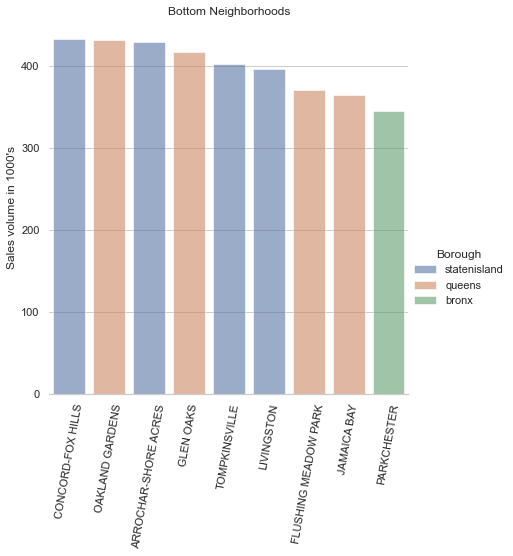

In [40]:
#Bottom 10 neighborhoods by average sales

#{1:'manhattan', 2:'bronx', 3:'brooklyn', 4:'queens', 5:'statenisland'}

bot_neigh = sales_22[['neighborhood','borough','sale_inthousands']]
nbhood_bot_avg_sales = bot_neigh.groupby('neighborhood').agg({'sale_inthousands':'mean','borough':'first'})
nbhood_bot_avg_sales.reset_index(inplace=True)
nbhood10_bot_avg_sales = nbhood_bot_avg_sales.sort_values(by='sale_inthousands' , ascending=False).iloc[-10:-1,:]
nbhood10_bot_avg_sales['borough'].replace({1:'manhattan', 2:'bronx', 3:'brooklyn', 4:'queens', 5:'statenisland'}, inplace=True)

#graph it

sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=nbhood10_bot_avg_sales, kind="bar",
    x="neighborhood", y="sale_inthousands", hue="borough", dodge=False,
    palette="deep", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Sales volume in 1000's")
g.legend.set_title("Borough")
g.set_xticklabels(rotation=80)

plt.title('Bottom Neighborhoods')
plt.show()


None of the lowest volume sales neighborhoods are located in Manhattan and Brooklyn 

In [41]:
## What is the amount mean sales by borough?

avg_sales_borough_2022 = sales_22[['borough','sale_inthousands']].groupby('borough').agg(['count','mean'])
avg_sales_borough_2022.reset_index(inplace=True)

avg_sales_borough_2022[(         'borough',      '')].replace({1:'manhattan', 2:'bronx', 3:'brooklyn', 4:'queens', 5:'statenisland'}, inplace=True)

avg_sales_borough_2022.columns = ['borough','sale_count','mean_sale_inthousands']

##   **** needs a graph ****

avg_sales_borough_2022

,borough,sale_count,mean_sale_inthousands
0,manhattan,7051,4119.381012
1,bronx,1909,1391.542957
2,brooklyn,7107,1722.910219
3,queens,7360,1187.970053
4,statenisland,2115,748.383229


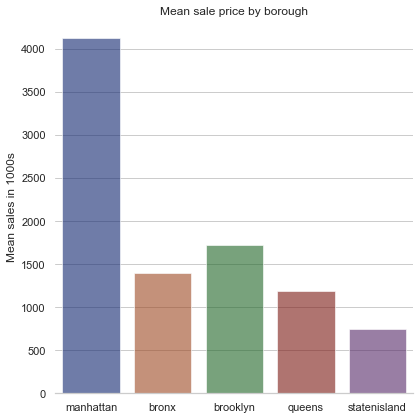

In [46]:
g = sns.catplot(
    data=avg_sales_borough_2022, kind="bar",
    x="borough", y="mean_sale_inthousands",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Mean sales in 1000s")

plt.title('Mean sale price by borough')
plt.show()

Again, our top contender for this metric is Manhattan, followed by Brooklyn with less than half the average sale price for the year 2022

## Extracting 2021 NYC sales for comparison 

Now that we have seen some general trends for 2022 sales in NYC, we can bring in the data for 2021 sales and analyze how sales in 2022 compare to the sales in the same period of the previous year. Considering covid-related effects, we can be fairly certain that conditions were significantly different between the two years.

In [48]:
## Indentify the urls and filenames for the 2021 data 

url_man_21 = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2021/2021_manhattan.xlsx'
url_brx_21 = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2021/2021_bronx.xlsx'
url_bry_21 = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2021/2021_brooklyn.xlsx'
url_que_21 = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2021/2021_queens.xlsx'
url_sta_21 = 'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2021/2021_staten_island.xlsx'


urls = [url_man_21,url_brx_21, url_bry_21, url_que_21, url_sta_21]
       #url_man_20,url_brx_20, url_bry_20, url_que_20, url_sta_20,
       #url_man_19,url_brx_19, url_bry_19, url_que_19, url_sta_19]

file_man_21 = '2021_manhattan.xlsx'
file_brx_21 = '2021_bronx.xlsx'
file_bry_21 = '2021_brooklyn.xlsx'
file_que_21 = '2021_queens.xlsx'
file_sta_21 = '2021_staten_island.xlsx'


filenames = [file_man_21, file_brx_21, file_bry_21, file_que_21, file_sta_21]
            #file_man_20, file_brx_20, file_bry_20, file_que_20, file_sta_20,
            #file_man_19, file_brx_19, file_bry_19, file_que_19, file_sta_19]


for i in range(5):
    urlretrieve(urls[i],filenames[i])

In [49]:
## Read our files with pandas

sales_man_21 = pd.read_excel('2021_manhattan.xlsx', header = 6)
sales_brx_21 = pd.read_excel('2021_bronx.xlsx', header = 6)
sales_bry_21 = pd.read_excel('2021_brooklyn.xlsx', header = 6)
sales_que_21 = pd.read_excel('2021_queens.xlsx', header = 6)
sales_sta_21 = pd.read_excel('2021_staten_island.xlsx', header = 6)


In the following steps we are going to do similar cleaning and formatting that we did for the sales data for 2021:

In [52]:
#Join the borough data together 

sales_21 = pd.concat([sales_man_21, sales_brx_21, sales_bry_21, sales_que_21, sales_sta_21])

In [53]:
# replace space by _ in column names

sales_21.columns = sales_21.columns.str.lower()
sales_21.columns = sales_21.columns.str.replace(" ", "_")

In [54]:
# take out the \n in column names 

sales_21.columns = sales_21.columns.str.replace("\n", "")

In [55]:
sales_21.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99095 entries, 0 to 9865
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   borough                        99090 non-null  float64       
 1   neighborhood                   99090 non-null  object        
 2   building_class_category        99090 non-null  object        
 3   tax_class_at_present           98919 non-null  object        
 4   block                          99090 non-null  float64       
 5   lot                            99090 non-null  float64       
 6   ease-ment                      0 non-null      float64       
 7   building_class_at_present      98919 non-null  object        
 8   address                        99090 non-null  object        
 9   apartment_number               24974 non-null  object        
 10  zip_code                       99089 non-null  float64       
 11  residentialunits

In [56]:
## drop the easement column because it is empty 

sales_21.drop(columns='ease-ment', inplace=True)

In [57]:
sales_21.head(3)

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,address,apartment_number,zip_code,residentialunits,commercialunits,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_classat_time_of_sale,sale_price,sale_date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,1.0,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,374.0,46.0,A4,347 EAST 4TH STREET,NaN,10009.0,1.0,0.0,1.0,2116.0,4400.0,1900.0,1.0,A4,2385000.0,2021-02-09
2,1.0,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377.0,70.0,B1,235 EAST 7TH STREET,NaN,10009.0,2.0,0.0,2.0,882.0,2160.0,2003.0,1.0,B1,3025000.0,2021-12-16


In [58]:
#reset our index after concat and drop the first row after columns that seems to be empty

sales_21.reset_index(inplace=True,drop=True)

sales_21.drop(index=0, inplace=True)

In [60]:
## change category-like columns into categories

obj_cats = ['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'building_class_at_present','zip_code',
            'year_built', 'tax_class_at_time_of_sale','building_classat_time_of_sale',
           'address','apartment_number']
            

for colname in obj_cats:
    sales_21[colname] = sales_21[colname].astype('category') 


In [61]:
# create a month column

sales_21['sale_month'] = sales_21['sale_date'].dt.to_period('M')

In [62]:
# create additional sales columns for easier visualization

sales_21['sale_inthousands'] = sales_21['sale_price']/1000
sales_21['sale_inmillions'] = sales_21['sale_price']/1000000

In [63]:
# take out sales under a thousand like we did with 22 sales

sales_21 = sales_21[~sales_21['sale_price'].between(0,999)]

In [64]:
## lets look at overall shape of numbers

## The shape of the quantitative columns seem similar to 2022

sales_21.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
residentialunits,50326.0,3.332035e+00,2.602727e+01,0.000,1.000,1.0,2.00,4.680000e+02
commercialunits,34229.0,3.989307e-01,1.321097e+01,0.000,0.000,0.0,0.00,2.261000e+03
total_units,52689.0,3.441762e+00,2.759115e+01,0.000,1.000,1.0,2.00,2.261000e+03
land_square_feet,31866.0,7.417172e+03,1.298219e+05,0.000,2000.000,2500.0,4000.00,5.799632e+06
gross_square_feet,31866.0,7.021528e+03,5.259943e+04,0.000,1322.000,1844.0,2680.00,2.400000e+06
sale_price,71053.0,1.948758e+06,9.631492e+06,1000.000,525000.000,800000.0,1350000.00,1.033000e+09
sale_inthousands,71053.0,1.948758e+03,9.631492e+03,1.000,525.000,800.0,1350.00,1.033000e+06
sale_inmillions,71053.0,1.948758e+00,9.631492e+00,0.001,0.525,0.8,1.35,1.033000e+03


Now that we have both 2022 sales and 2021 sales, and they are formatted similarly, we can look at year to year changes. We are going to grap the first quarter of the year for 2021 and 2022 and see changes in prices for a specific type of building:

In [67]:
#extract building class number and put in diff column for year 21

sales_21['building_class_num'] = 'type' + sales_21['building_class_category'].str[:2]
sales_21['building_class_num']

/var/folders/76/ytg4_01s0zj0zkszt775_g3h0000gn/T/ipykernel_21448/4038131272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_21['building_class_num'] = 'type' + sales_21['building_class_category'].str[:2]


1        type01
2        type02
3        type07
5        type07
6        type07
          ...  
99090    type02
99091    type03
99092    type05
99093    type05
99094    type05
Name: building_class_num, Length: 71057, dtype: object

In [68]:
#extract building class number and put in diff column for year 22

sales_22['building_class_num'] = 'type' + sales_22['building_class_category'].str[:2]
sales_22['building_class_num']

0        type07
1        type07
2        type07
3        type07
4        type07
          ...  
25537    type02
25538    type02
25539    type02
25540    type02
25541    type02
Name: building_class_num, Length: 25542, dtype: object

In [69]:
# extract first quarter of 2022 sales to compare

sales_22_q1 = sales_22[sales_22['sale_date'].dt.month.between(0,3)]

In [70]:
# extract first quarter of 2021 sales to compare 

sales_21_q1 = sales_21[sales_21['sale_date'].dt.month.between(0,3)]

We are going to grab apartment-type buildings, which are labeled with the types below:

In [71]:
# we will look at apartment-type buildings -  q1 difference between year 21 and 22

apartment_types_num = ['type10','type13','type09','type15','type04','type07','type17','type12']

In [72]:
#Separate apartment type buildings'

sales_apart_21_q1 = sales_21_q1[sales_21_q1['building_class_num'].isin(apartment_types_num)]
sales_apart_22_q1 = sales_22_q1[sales_22_q1['building_class_num'].isin(apartment_types_num)]

In [73]:
sales_apart_22_q1['building_class_num'].value_counts()

type13    3425
type10    3345
type09     623
type07     444
type15     412
type17     337
type04     313
type12     195
Name: building_class_num, dtype: int64

In [80]:
#groupby building type 


### *** do for both 21 and 22 and then graph it 

sale_build_21 = sales_apart_21_q1[['building_class_num','building_class_category','sale_inthousands']]
sale_build_22 = sales_apart_22_q1[['building_class_num','building_class_category','sale_inthousands']]

sb21 = sale_build_21.groupby('building_class_num').agg({'building_class_category':'first','sale_inthousands':'mean'})
sb22 = sale_build_22.groupby('building_class_num').agg({'building_class_category':'first','sale_inthousands':'mean'})

#sb21.sort_values(by='sale_inthousands', ascending=False),sb22.sort_values(by='sale_inthousands', ascending=False)
  
sb21_22 = pd.concat([sb21,sb22])
sb21_22['year'] = [2021,2021,2021,2021,2021,2021,2021,2021,2022,2022,2022,2022,2022,2022,2022,2022]
sb21_22

,building_class_category,sale_inthousands,year
building_class_num,,,
type04,04 TAX CLASS 1 CONDOS,629.519667,2021
type07,07 RENTALS - WALKUP APARTMENTS,2504.266444,2021
type09,09 COOPS - WALKUP APARTMENTS,606.614817,2021
type10,10 COOPS - ELEVATOR APARTMENTS,803.638468,2021
type12,12 CONDOS - WALKUP APARTMENTS,873.011183,2021
type13,13 CONDOS - ELEVATOR APARTMENTS,1716.757788,2021
type15,15 CONDOS - 2-10 UNIT RESIDENTIAL,1348.215527,2021
type17,17 CONDO COOPS,917.519195,2021
type04,04 TAX CLASS 1 CONDOS,787.204147,2022


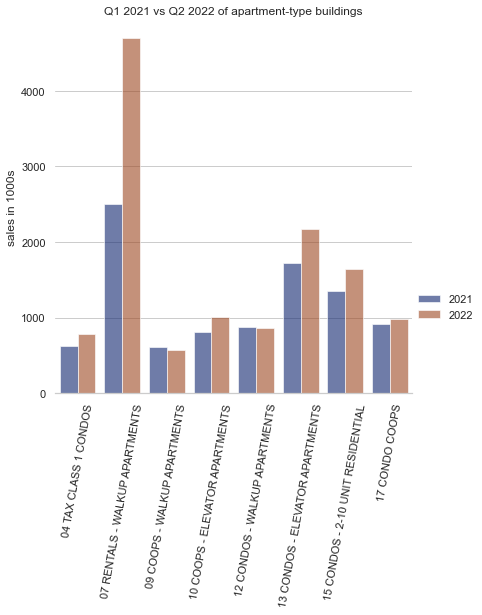

In [81]:
#lets visualize it

g = sns.catplot(
    data=sb21_22, kind="bar",
    x="building_class_category", y="sale_inthousands", hue="year",
    ci="sd", palette="dark", alpha=.6, height=6, 
)
g.despine(left=True)
g.set_axis_labels("", "sales in 1000s")
g.legend.set_title("")
g.set_xticklabels(rotation=80)

plt.title('Q1 2021 vs Q2 2022 of apartment-type buildings')
plt.show()

For apartment-type buildings, there has been a significant increase in sales volume across all types of buildings year to year in quarter 1.

In [103]:
## lets look at q1 difference between years for boroughs (mean)

sale_bor_21 = sales_apart_21_q1[['borough','sale_inthousands']]
sale_bor_22 = sales_apart_22_q1[['borough','sale_inthousands']]

sbor21 = sale_bor_21.groupby('borough').agg({'borough':'first','sale_inthousands':'mean'})
sbor22 = sale_bor_22.groupby('borough').agg({'borough':'first','sale_inthousands':'mean'})

sbor21.reset_index(inplace=True,drop=True)
sbor22.reset_index(inplace=True,drop=True)

sbor21['borough'].replace({1:'manhattan', 2:'bronx', 3:'brooklyn', 4:'queens', 5:'statenisland'}, inplace=True)
sbor22['borough'].replace({1:'manhattan', 2:'bronx', 3:'brooklyn', 4:'queens', 5:'statenisland'}, inplace=True)

a1 = sbor21.sort_values(by='sale_inthousands', ascending=False)
b1 = sbor22.sort_values(by='sale_inthousands', ascending=False)
c1 = pd.concat([a1,b1['sale_inthousands']],axis=1)
c1.columns = ['borough','2021 Q1','2022 Q2']
d1 = pd.melt(c1, id_vars=['borough'], value_vars=['2021 Q1','2022 Q2'],var_name= 'year',value_name='sale_price_inthousands')
d1

,borough,year,sale_price_inthousands
0,manhattan,2021 Q1,1786.924305
1,brooklyn,2021 Q1,983.699918
2,queens,2021 Q1,521.854332
3,bronx,2021 Q1,451.264661
4,statenisland,2021 Q1,374.806860
5,manhattan,2022 Q2,2331.573420
6,brooklyn,2022 Q2,1111.488045
7,queens,2022 Q2,959.498722
8,bronx,2022 Q2,626.317542
9,statenisland,2022 Q2,474.261684


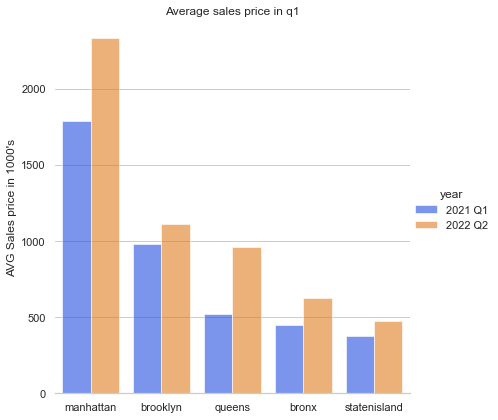

In [113]:
g = sns.catplot(
    data=d1, kind="bar",
    x="borough", y="sale_price_inthousands", hue="year",
    ci="sd", palette="bright", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "AVG Sales price in 1000's")

plt.title('Average sales price in q1')
plt.show()

There has been an increase in average prices across the board in all boroughs of NYC year to year in Q1

Now, total sales volume comparison between the years:

In [108]:
## lets look at q1 difference between years for boroughs (sum)

sale_bor_21 = sales_apart_21_q1[['borough','sale_inmillions']]
sale_bor_22 = sales_apart_22_q1[['borough','sale_inmillions']]

sumbor21 = sale_bor_21.groupby('borough').agg({'borough':'first','sale_inmillions':'sum'})
sumbor22 = sale_bor_22.groupby('borough').agg({'borough':'first','sale_inmillions':'sum'})

sumbor21.reset_index(inplace=True,drop=True)
sumbor22.reset_index(inplace=True,drop=True)

sumbor21['borough'].replace({1:'manhattan', 2:'bronx', 3:'brooklyn', 4:'queens', 5:'statenisland'}, inplace=True)
sumbor22['borough'].replace({1:'manhattan', 2:'bronx', 3:'brooklyn', 4:'queens', 5:'statenisland'}, inplace=True)

a2 = sumbor21.sort_values(by='sale_inmillions', ascending=False)
b2 = sumbor22.sort_values(by='sale_inmillions', ascending=False)
c2 = pd.concat([a2,b2['sale_inmillions']],axis=1)
c2.columns = ['borough','2021 Q1','2022 Q2']
d2 = pd.melt(c2, id_vars=['borough'], value_vars=['2021 Q1','2022 Q2'],var_name= 'year',value_name='sale_price_inmillions')
d2

,borough,year,sale_price_inmillions
0,manhattan,2021 Q1,5491.218389
1,brooklyn,2021 Q1,1868.046144
2,queens,2021 Q1,830.270243
3,bronx,2021 Q1,174.639424
4,statenisland,2021 Q1,69.714076
5,manhattan,2022 Q2,9864.887141
6,brooklyn,2022 Q2,2549.753575
7,queens,2022 Q2,1891.171981
8,bronx,2022 Q2,265.558638
9,statenisland,2022 Q2,82.521533


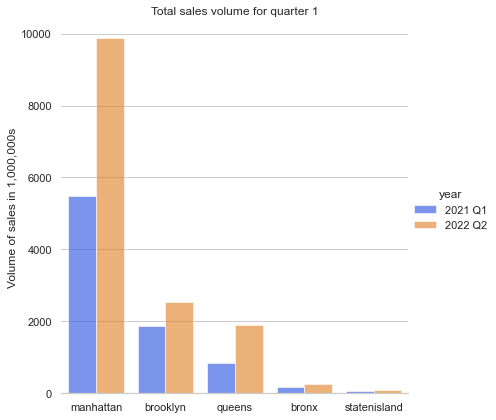

In [112]:
g = sns.catplot(
    data=d2, kind="bar",
    x="borough", y="sale_price_inmillions", hue="year",
    ci="sd", palette="bright", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Volume of sales in 1,000,000s")

plt.title('Total sales volume for quarter 1')
plt.show()

Like mean prices, the overall volume has increased significantly year over year. Manhattan dominates the sales volumes overall for the 5 boroughs

With a good overview of sales in NYC, we might also want to explore other variables that may be affecting the value of buildings across the city. A common thing to look at is vacancy, which we have data on provided by the local goverment of NYC here: https://data.cityofnewyork.us/City-Government/Storefronts-Reported-Vacant-or-Not/92iy-9c3n

## Storefronts reported vacant

This data set provides us with data on storefronts vacancies. Storefront vacancies have a negative social effects on communities and also a negative effect on sales prices for properties. Lets first start with what type of businesses have the most storefront across all 5 boroughs.

In [85]:
# What type of businesses have storefronts in NYC?

vacancy = pd.read_csv('Storefronts_Reported_Vacant_or_Not.csv')
vacancy['PRIMARY BUSINESS ACTIVITY'].value_counts()

RETAIL                              42382
FOOD SERVICES                       28313
OTHER                               23842
NO BUSINESS ACTIVITY IDENTIFIED     21570
MISCELLANEOUS OTHER SERVICE         10974
HEALTH CARE or SOCIAL ASSISTANCE     4531
HEALTH CARE OR SOCIAL ASSISTANCE     4213
FINANCE & INSURANCE                  3681
REAL ESTATE                          3338
EDUCATIONAL SERVICES                 1837
WHOLESALE                            1733
ACCOUNTING SERVICES                  1179
LEGAL SERVICES                        895
MANUFACTURING                         834
INFORMATION SERVICES                  567
BROADCASTING/TELECOMM                 480
MOVIES/VIDEO/SOUND                    330
PUBLISHING                             91
Name: PRIMARY BUSINESS ACTIVITY, dtype: int64

It seems intuitive that the most common ones are retail stores and restaurant-type businesses. That is what one sees the most walking around the streets of NYC.

In [87]:
## There are alot of columns we are not interested in at the moment for looking at vacancy 

vacancy.columns

Index(['Reporting Year', 'BOROUGH-BLOCK-LOT',
       'PROPERTY STREET ADDRESS OR STOREFRONT ADDRESS', 'BOROUGH', 'ZIP CODE',
       'SOLD DATE', 'VACANT ON 12/31', 'CONSTRUCTION REPORTED',
       'VACANT 6/30 OR DATE SOLD IF EARLIER', 'PRIMARY BUSINESS ACTIVITY',
       'PROPERTY NUMBER', 'PROPERTY STREET', 'UNIT', 'BOROUGH 1', 'POSTCODE',
       'LATITUDE', 'LONGITUDE', 'COMMUNITY BOARD', 'COUNCIL DISTRICT',
       'CENSUS TRACT', 'BIN', 'BBL', 'NTA', 'NBHD'],
      dtype='object')

In [88]:
# Number of reports for each year are about the same

vacancy['Reporting Year'].value_counts()

2020 and 2021    75540
2019 and 2020    75250
Name: Reporting Year, dtype: int64

In [89]:
#sold date and construction reported seem to be small enough that we can ignore for now 

vacancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150790 entries, 0 to 150789
Data columns (total 24 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Reporting Year                                 150790 non-null  object 
 1   BOROUGH-BLOCK-LOT                              150790 non-null  int64  
 2   PROPERTY STREET ADDRESS OR STOREFRONT ADDRESS  150789 non-null  object 
 3   BOROUGH                                        150790 non-null  object 
 4   ZIP CODE                                       149719 non-null  float64
 5   SOLD DATE                                      201 non-null     object 
 6   VACANT ON 12/31                                150790 non-null  object 
 7   CONSTRUCTION REPORTED                          881 non-null     object 
 8   VACANT 6/30 OR DATE SOLD IF EARLIER            7142 non-null    object 
 9   PRIMARY BUSINESS ACTIVITY            

In the next few steps, we are going to quickly clean and format in a similar way to what we did to sales data:

In [90]:


vacancy.columns = vacancy.columns.str.lower()
vacancy.columns = vacancy.columns.str.replace(" ", "_")

In [91]:
# we are going to droop the individually identifying information 
# and anything more specific than neighborhood

vacancy.drop(columns=['property_street_address_or_storefront_address','borough-block-lot',
                      'property_number', 'property_street', 'unit', 'borough_1', 'postcode',
       'latitude', 'longitude', 'community_board', 'council_district','zip_code',
       'census_tract', 'bbl', 'nta', 'nbhd','sold_date'], inplace=True)

In [92]:
# formatting vacancy columns

vacancy['vacant_on_12/31'].replace({'YES':True,'NO':False},inplace=True)
vacancy['vacant_6/30_or_date_sold_if_earlier'].replace({'YES':True,np.nan:False},inplace=True)

In [93]:
vacancy.rename(columns={'vacant_6/30_or_date_sold_if_earlier':'vacant_on_6/30'},inplace=True)

In [94]:
len(vacancy[vacancy['vacant_on_12/31']]),len(vacancy[vacancy['vacant_on_6/30']==True])

(15482, 7142)

For clarity, we are going to focus on vacancies as of the end of June for both years:

In [97]:
#We are going to focus on the vacancies during end of june for both years 

vacancy_midyear = vacancy[['reporting_year','primary_business_activity','borough','vacant_on_6/30']]
vacancy_midyear.rename(columns={'reporting_year':'year'},inplace=True)
vacancy_midyear['year'].replace({'2019 and 2020':'2020','2020 and 2021':'2021'},inplace=True)
v_my = vacancy_midyear[['year','borough','vacant_on_6/30']].groupby(['borough','year']).count()
v_my.reset_index(inplace=True)
v_my

/Users/snoopymartinmar/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/Users/snoopymartinmar/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,borough,year,vacant_on_6/30
0,BRONX,2020,10474
1,BRONX,2021,10569
2,BROOKLYN,2020,17962
3,BROOKLYN,2021,18202
4,MANHATTAN,2020,26819
5,MANHATTAN,2021,26723
6,QUEENS,2020,16662
7,QUEENS,2021,16757
8,STATEN ISLAND,2020,3333
9,STATEN ISLAND,2021,3289


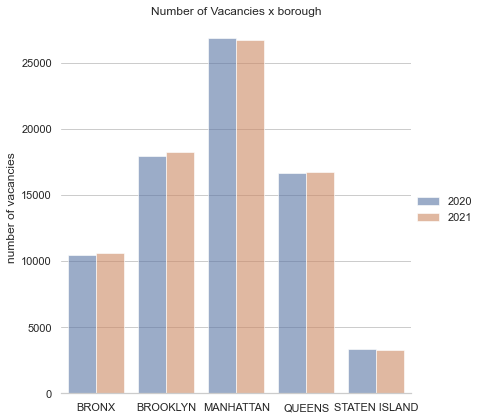

In [98]:
g = sns.catplot(
    data=v_my, kind="bar",
    x="borough", y="vacant_on_6/30", hue="year",
    ci="sd", palette="deep", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "number of vacancies")
g.legend.set_title("")

plt.title('Number of Vacancies x borough')
plt.show()

The change seems to be very small compared to the overall amount of vacant storefronts. This would require further research to see why these numbers don't change very much and understand which factors affect vacancy rates.

## Conclusion 

There has been a significant increase in sales prices year over year across all 5 boroughs, in terms of average sale price and volume. Manhattan dominates in terms of sales volume for properties. It would be interesting to investigate how much of the price our 4 positively-correlated quantitative columns can explain. Also, creating a vacancy rate and adding that to the regression (along with other indexes) in order to try to explain prices can help us create a fairly strong model for predicting prices in the NYC area. 